In [1]:
!pwd
!conda env list

/usr/project/xtmp/par55/DiffScaler/notebooks
/bin/bash: line 1: conda: command not found


In [2]:
import sys
import os
sys.path.append('/usr/project/xtmp/par55/DiffScaler')
os.chdir('/usr/project/xtmp/par55/DiffScaler')
import torch
from tqdm import tqdm
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightning as L
seed = 150
L.seed_everything(seed, workers=True)

from src.models.unet_module import UnetLitModule
from src.models.gan_module import UnetGANLitModule
from src.models.ae_module import AutoencoderKL, EncoderLRES
from src.models.ldm_module import LatentDiffusion

from src.models.components.unet import DownscalingUnet
from src.models.components.ae import SimpleConvDecoder, SimpleConvEncoder
from src.models.components.ldm.denoiser import UNetModel, DDIMSampler
from src.models.components.ldm.conditioner import AFNOConditionerNetCascade
from src.data.downscaling_datamodule import DownscalingDataModule
from src.data.components.downscaling_dataset import DownscalingDataset 

from utils.inference_utils import get_model_output
from utils.plotting_utils import get_target_grid, from_torchtensor_to_xarray 


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/users/par55/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
[rank: 0] Global seed set to 150


Pysteps configuration file found at: /home/users/par55/.local/lib/python3.10/site-packages/pysteps/pystepsrc



In [3]:


# Set paths
trained_models_path = './pretrained_models/'
data_path = './data/'
output_path = './outputs/'


static_vars = {'dtm_tif_file': data_path + 'static_var/dtm_2km_domain_trim_EPSG3035.tif',
               'lc_tif_file': data_path + 'static_var/land_cover_classes_2km_domain_trim_EPSG3035.tif',
               'lat_tif_file': data_path + 'static_var/lat_2km_domain_trim_EPSG3035.tif'}

borders_file = data_path + 'plotting_resources/borders_downscaling_domain_3035.geojson'

# Read in the data normalization info
with open(data_path + 'normalization_data.pkl', 'rb') as f:
    norm_values = pickle.load(f)

# Fix number of test timestep to perform
nr_timesteps = 5

In [4]:
# Choose the target variables (either '2mT' or 'UV')
target_var = '2mT'
#target_var = 'UV'

target_channels = 1 if target_var == '2mT' else 2
target_vars = {'high_res': ['2mT']} if target_var == '2mT' else {'high_res': ['U10', 'V10']}
target_vars['low_res'] = ['2mT', 'PMSL', 'U10', 'V10', 'dp2mT', 'SST', 'SNDPT', 'TP', 'SSRadIn', 'Q850', 'T850', 'U850', 'V850', 'W850']

tv_idxs = {}
for tv in target_vars['high_res']:
    tv_idxs[tv] = [i for i in range(len(target_vars['low_res'])) if target_vars['low_res'][i] == tv][0]

100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


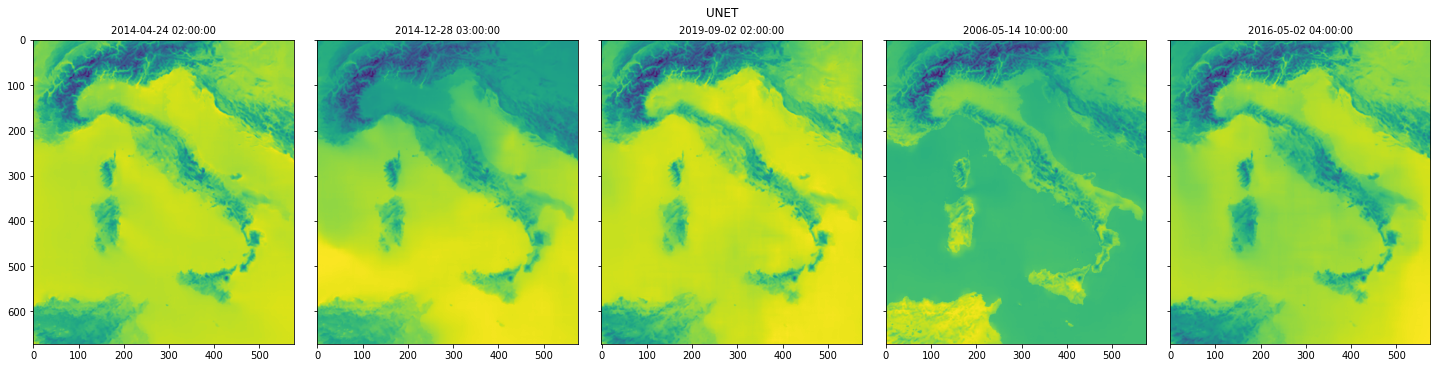

In [5]:
# Load the UNET model 
ckpt_ref_file = trained_models_path + 'UNET_' + target_var + '.ckpt'
loss = torch.nn.Identity()
in_ch = 18 + 14  # 18 static variables + 14 predictors
out_ch = target_channels
unet_model = UnetLitModule.load_from_checkpoint(ckpt_ref_file,
                                           net=DownscalingUnet(in_ch=in_ch,out_ch=out_ch),
                                           loss=loss,
                                           ckpt_path=None,
                                           strict=False).eval().to(device='cuda:0') 

nn_lowres = True
# Set up test dataloader
data_module_unet = DownscalingDataModule(data_dir=data_path, 
                                    target_vars=target_vars,
                                    batch_size=1,
                                    num_workers=1)
data_module_unet.data_test = DownscalingDataset(data_path,
                                              target_vars=target_vars,
                                              nn_lowres=nn_lowres,
                                              static_vars=static_vars, 
                                              metadata_file_name='metadata_test_paper_sample.csv')
test_dataloader_unet = data_module_unet.test_dataloader()
test_iter_unet = iter(test_dataloader_unet)
unet_preds_norm = {}
# Run the UNET on the test dataset
for idx_preds in tqdm(range(0,nr_timesteps)):           
    el = next(test_iter_unet)
    model_output, ts_ns = get_model_output('unet-like', unet_model, el)
    ts_ns = pd.to_datetime(int(ts_ns))
    unet_preds_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        unet_preds_norm[ts_ns][tv] = model_output.cpu()[0,index,:,:]* norm_values['CMCC']['std'][tv] + norm_values['CMCC']['mean'][tv]
    if target_var == 'UV':
        unet_preds_norm[ts_ns]['WS10'] = np.sqrt(unet_preds_norm[ts_ns]['U10'] **2 + unet_preds_norm[ts_ns]['V10']**2)

# Plot data
plot_var = '2mT' if target_var=='2mT' else 'WS10'
fig, ax_unet = plt.subplots(ncols=nr_timesteps,figsize=(4*nr_timesteps,5),sharey=True, sharex=True, constrained_layout=True)
ax_unet = np.atleast_1d(ax_unet)
fig.suptitle('UNET')
for idx_preds,ts_ns in enumerate(unet_preds_norm):
    ax_unet[idx_preds].imshow(unet_preds_norm[ts_ns][plot_var])
    ax_unet[idx_preds].set_title(ts_ns, fontsize=10) 

/home/users/par55/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
/home/users/par55/.local/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:164: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['loss.discriminator.main.0.weight', 'loss.discriminator.main.0.bias', 'loss.discriminator.main.2.weight', 'loss.discriminator.main.3.weight', 'loss.discriminator.main.3.bias', 'loss.discriminator.main.3.running_mean', 'loss.discriminator.main.3.running_var', 'loss.discriminator.main.3.num_batches_tracked', 'loss.discriminator.main.5.weight', 'loss.discriminator.main.6.weight', 'loss.discriminator.main.6.bias', 'loss.discriminator.main.6.running_mean', 'loss.discriminator.main.6.running_var', 'loss.discriminator.main

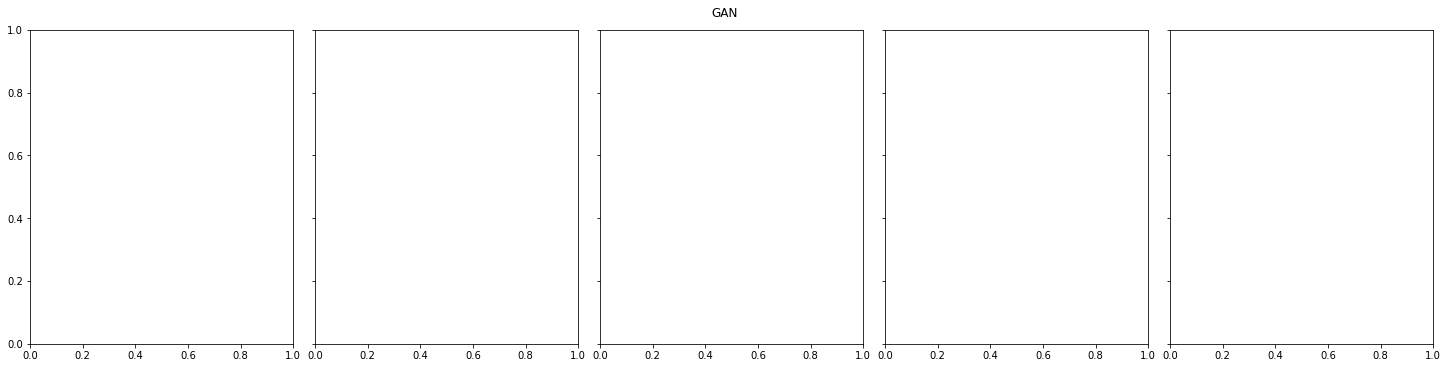

In [6]:
# Load the GAN model
ckpt_ref_file = trained_models_path + 'GAN_' + target_var + '.ckpt'
loss = torch.nn.Identity()
in_ch = 18 + 14  # 18 static variables + 14 predictors
out_ch = target_channels
gan_model = UnetGANLitModule.load_from_checkpoint(ckpt_ref_file,
                                              net=DownscalingUnet(in_ch=in_ch,out_ch=out_ch),
                                              loss=loss,
                                              ckpt_path=None,
                                              strict=False).eval().to(device='cuda:0')
nn_lowres = True
# Set up test dataloader
data_module_gan = DownscalingDataModule(data_dir=data_path, 
                                    target_vars=target_vars,
                                    batch_size=1,
                                    num_workers=1)
data_module_gan.data_test = DownscalingDataset(data_path,
                                              target_vars=target_vars,
                                              nn_lowres=nn_lowres,
                                              static_vars=static_vars, 
                                              metadata_file_name='metadata_test_paper_sample.csv')
test_dataloader_gan = data_module_gan.test_dataloader()
test_iter_gan = iter(test_dataloader_gan)
gan_preds_norm = {}
# Run the GAN on the test dataset
for idx_preds in tqdm(range(0,nr_timesteps)):           
    el = next(test_iter_gan)
    model_output, ts_ns = get_model_output('unet-like', gan_model, el)
    ts_ns = pd.to_datetime(int(ts_ns))
    gan_preds_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        gan_preds_norm[ts_ns][tv] = model_output.cpu()[0,index,:,:]* norm_values['CMCC']['std'][tv] + norm_values['CMCC']['mean'][tv]
    if target_var == 'UV':
        gan_preds_norm[ts_ns]['WS10'] = np.sqrt(gan_preds_norm[ts_ns]['U10'] **2 + gan_preds_norm[ts_ns]['V10']**2)

# Plot data
plot_var = '2mT' if target_var=='2mT' else 'WS10'
fig, ax_gan = plt.subplots(ncols=nr_timesteps,figsize=(4*nr_timesteps,5),sharey=True, sharex=True, constrained_layout=True)
ax_gan = np.atleast_1d(ax_unet)
fig.suptitle('GAN')
for idx_preds,ts_ns in enumerate(gan_preds_norm):
    ax_gan[idx_preds].imshow(gan_preds_norm[ts_ns][plot_var])
    ax_gan[idx_preds].set_title(ts_ns, fontsize=10) 


100%|██████████| 5/5 [01:02<00:00, 12.51s/it]


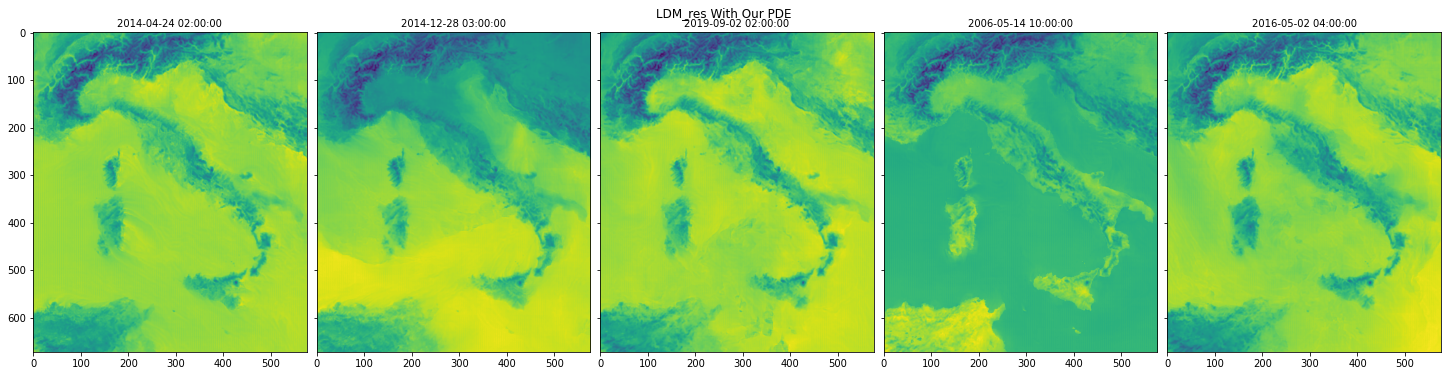

In [7]:


# File paths 
ckpt_ref_file = trained_models_path + 'LDM_residual_' + target_var + '.ckpt'
#ckpt_partial_file = "/usr/project/xtmp/par55/DiffScaler/logs/train/runs/2025-04-08_01-12-55/checkpoints/epoch_000.ckpt"
#longest trained ckpt_partial_file = "/usr/project/xtmp/par55/DiffScaler/logs/train/runs/2025-04-08_11-18-46/checkpoints/epoch_002.ckpt"
ckpt_partial_file = "/usr/project/xtmp/par55/DiffScaler/logs/train/runs/2025-04-08_11-12-06/checkpoints/epoch_000.ckpt"
#ACTUAL BEST: ckpt_partial_file = "/usr/project/xtmp/par55/DiffScaler/logs/train/runs/2025-04-08_14-13-42/checkpoints/epoch_000.ckpt"
ae_ckpt_ref_file = trained_models_path + 'VAE_residual_' + target_var + '.ckpt'

# Model hyper-parameters 
in_dim = target_channels
parameterization = 'v'
ae_flag = 'residual'
unet_regr = unet_model  # assume unet_model is defined

# ----- STEP 1: Combine Checkpoints -----
# Load the full (reference) checkpoint state dict.
full_ckpt = torch.load(ckpt_ref_file, map_location='cuda:0', weights_only=False)
# Load the partial checkpoint state dict (the one with frozen parameters).
partial_ckpt = torch.load(ckpt_partial_file, map_location='cuda:0', weights_only=False)

# Get the state dictionaries from each checkpoint.
state_full = full_ckpt["state_dict"]
state_partial = partial_ckpt["state_dict"]

# Combine: use the values in state_partial to override the full state.
combined_state = state_full.copy()
combined_state.update(state_partial)
# (Now any missing keys in the partial checkpoint are filled in from the full checkpoint)

# ----- STEP 2: Instantiate the Model -----
ldm_res_model = LatentDiffusion(
    denoiser=UNetModel(
                in_channels=32*in_dim,
                model_channels=256,
                out_channels=32*in_dim,
                num_res_blocks=2,
                attention_resolutions=[1,2],
                dims=2,
                channel_mult=[1,2,4],
                num_heads=8,
                context_ch=[256,512,1024]),
    autoencoder=AutoencoderKL(
                encoder=SimpleConvEncoder(in_dim=in_dim, levels=3),
                decoder=SimpleConvDecoder(in_dim=in_dim, levels=3),
                ae_flag=ae_flag, 
                unet_regr=unet_regr),
    context_encoder=AFNOConditionerNetCascade(
                autoencoder=[AutoencoderKL(encoder=SimpleConvEncoder(in_dim=18, levels=3, ch_mult=3),
                                            decoder=None),
                             EncoderLRES()],
                train_autoenc=False,
                cascade_depth=3,
                embed_dim=[128,24],
                analysis_depth=[4,4],
                afno_fusion=True,
                input_size_ratios=[1,1],
                embed_dim_out=256),
    ae_load_state_file=ae_ckpt_ref_file, 
    parameterization=parameterization
).to(device='cuda:0')

# ----- STEP 3: Load the Combined State Dictionary -----
# Use strict=False so that any (noncritical) missing keys are ignored.
ldm_res_model.load_state_dict(combined_state, strict=False)
ldm_res_model.eval()

# ----- STEP 4: Set Up the Test DataLoader and Sampler -----
nn_lowres = False
data_module_ldm = DownscalingDataModule(
    data_dir=data_path, 
    target_vars=target_vars,
    batch_size=1,
    num_workers=1)
data_module_ldm.data_test = DownscalingDataset(
    data_path,
    target_vars=target_vars,
    nn_lowres=nn_lowres,
    static_vars=static_vars, 
    metadata_file_name='metadata_test_paper_sample.csv')
test_dataloader_ldm = data_module_ldm.test_dataloader()
test_iter_ldm = iter(test_dataloader_ldm)

sampler = DDIMSampler(ldm_res_model)
denoising_steps = 100

# ----- STEP 5: Run Inference on the Test Dataset -----
ldm_preds_norm = {}
for idx_preds in tqdm(range(0, nr_timesteps)):
    el = next(test_iter_ldm)
    model_output, ts_ns = get_model_output('ldm', ldm_res_model, el, sampler=sampler, num_diffusion_iters=denoising_steps)
    ts_ns = pd.to_datetime(int(ts_ns))
    ldm_preds_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        ldm_preds_norm[ts_ns][tv] = model_output.cpu()[0, index, :, :] * norm_values['CMCC']['std'][tv] + norm_values['CMCC']['mean'][tv]
    if target_var == 'UV':
        ldm_preds_norm[ts_ns]['WS10'] = np.sqrt(ldm_preds_norm[ts_ns]['U10']**2 + ldm_preds_norm[ts_ns]['V10']**2)

# ----- STEP 6: Plot the Results -----
plot_var = '2mT' if target_var == '2mT' else 'WS10'
fig, ax_ldm = plt.subplots(ncols=nr_timesteps, figsize=(4*nr_timesteps, 5), sharey=True, sharex=True, constrained_layout=True)
fig.suptitle('LDM_res With Our PDE')
for idx_preds, ts_ns in enumerate(ldm_preds_norm):
    ax_ldm[idx_preds].imshow(ldm_preds_norm[ts_ns][plot_var])
    ax_ldm[idx_preds].set_title(str(ts_ns), fontsize=10)
plt.show()
#Save for later more plotting
ldm_preds_pde = ldm_preds_norm.copy()


/home/users/par55/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.0.5
  rank_zero_warn(
100%|██████████| 5/5 [01:02<00:00, 12.41s/it]


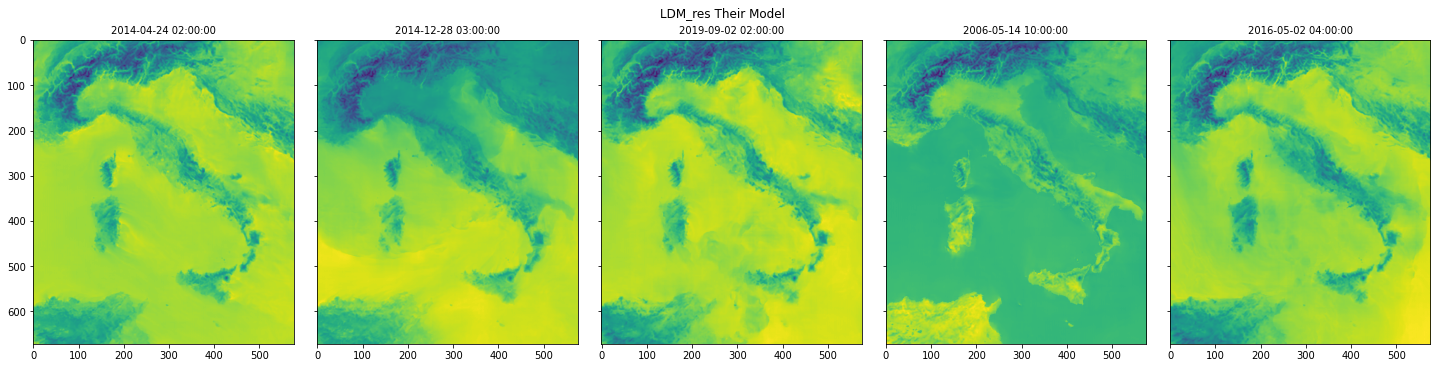

In [8]:
# Load the LDM_res model
ckpt_ref_file = trained_models_path + 'LDM_residual_' + target_var + '.ckpt'
ae_ckpt_ref_file = trained_models_path + 'VAE_residual_' + target_var + '.ckpt'
in_dim = target_channels
parameterization = 'v'
ae_flag = 'residual'
unet_regr = unet_model
ldm_res_model = LatentDiffusion.load_from_checkpoint(ckpt_ref_file,
                                            denoiser=UNetModel(in_channels=32*in_dim,
                                                            model_channels=256,
                                                            out_channels=32*in_dim,
                                                            num_res_blocks=2,
                                                            attention_resolutions=[1,2],
                                                            dims=2,
                                                            channel_mult=[1,2,4],
                                                            num_heads=8,
                                                            context_ch=[256,512,1024]),
                                            autoencoder=AutoencoderKL(encoder=SimpleConvEncoder(in_dim=in_dim, levels=3),
                                                                      decoder=SimpleConvDecoder(in_dim=in_dim, levels=3),
                                                                      ae_flag=ae_flag, 
                                                                      unet_regr=unet_regr),
                                            context_encoder=AFNOConditionerNetCascade(autoencoder=[AutoencoderKL(encoder=SimpleConvEncoder(in_dim=18,levels=3,ch_mult=3),
                                                                                                             decoder=None),
                                                                                               EncoderLRES()], 
                                                                                  train_autoenc=False,
                                                                                  cascade_depth=3,
                                                                                  embed_dim=[128,24],
                                                                                  analysis_depth=[4,4],
                                                                                  afno_fusion=True,
                                                                                  input_size_ratios=[1,1],
                                                                                  embed_dim_out=256),
                                            ae_load_state_file=ae_ckpt_ref_file, 
                                            parameterization=parameterization).eval().to(device='cuda:0')
nn_lowres = False
# Set up test dataloader
data_module_ldm = DownscalingDataModule(data_dir=data_path, 
                                    target_vars=target_vars,
                                    batch_size=1,
                                    num_workers=1)
data_module_ldm.data_test = DownscalingDataset(data_path,
                                              target_vars=target_vars,
                                              nn_lowres=nn_lowres,
                                              static_vars=static_vars, 
                                              metadata_file_name='metadata_test_paper_sample.csv')
test_dataloader_ldm = data_module_ldm.test_dataloader()
test_iter_ldm = iter(test_dataloader_ldm)
# Set up sampler
sampler = DDIMSampler(ldm_res_model)
denoising_steps = 100

ldm_preds_norm = {}
# Run the LDM on the test dataset
for idx_preds in tqdm(range(0,nr_timesteps)):          
    el = next(test_iter_ldm)
    model_output, ts_ns = get_model_output('ldm', ldm_res_model, el, sampler=sampler, num_diffusion_iters=denoising_steps)
    ts_ns = pd.to_datetime(int(ts_ns))
    ldm_preds_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        ldm_preds_norm[ts_ns][tv] = model_output.cpu()[0,index,:,:]* norm_values['CMCC']['std'][tv] + norm_values['CMCC']['mean'][tv]
    if target_var == 'UV':
        ldm_preds_norm[ts_ns]['WS10'] = np.sqrt(ldm_preds_norm[ts_ns]['U10'] **2 + ldm_preds_norm[ts_ns]['V10']**2)

# Plot data
plot_var = '2mT' if target_var=='2mT' else 'WS10'
fig, ax_ldm = plt.subplots(ncols=nr_timesteps,figsize=(4*nr_timesteps,5),sharey=True, sharex=True, constrained_layout=True)
fig.suptitle('LDM_res Their Model')
for idx_preds,ts_ns in enumerate(ldm_preds_norm):
    ax_ldm[idx_preds].imshow(ldm_preds_norm[ts_ns][plot_var])
    ax_ldm[idx_preds].set_title(ts_ns, fontsize=10) 



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  6.04it/s]


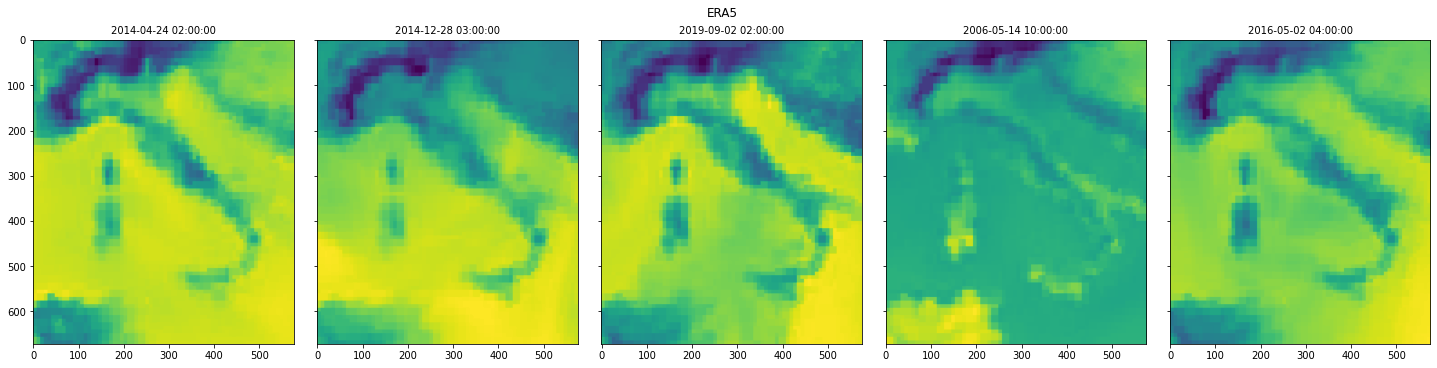

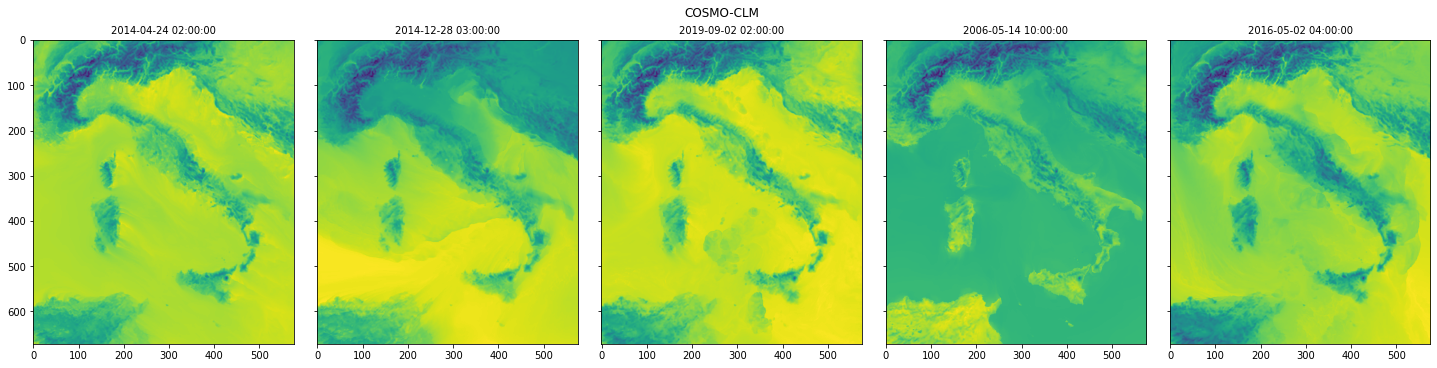

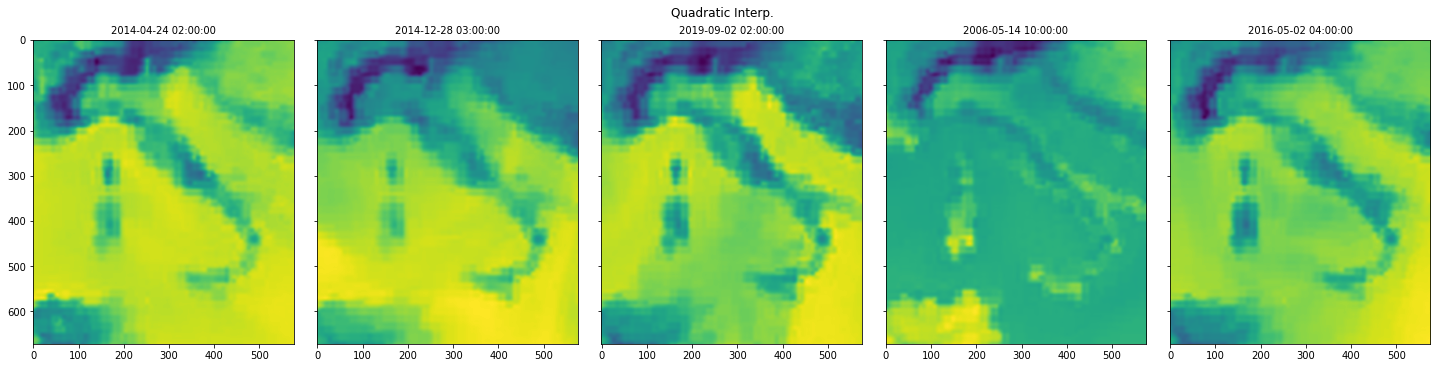

In [9]:
# Store ERA5 and COSMO-CLM baseline datasets
test_iter_unet = iter(test_dataloader_unet)
era5_norm = {}
cosmo_norm = {}

for idx_preds in tqdm(range(0,nr_timesteps)):
    el = next(test_iter_unet)
    low_res = el[0]
    high_res = el[1]
    ts_ns = pd.to_datetime(int(el[2]))
    era5_norm[ts_ns] = {}
    cosmo_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        era5_norm[ts_ns][tv] = low_res[0, tv_idxs[tv],:,:]* norm_values['ERA5']['std'][tv] + norm_values['ERA5']['mean'][tv]
        cosmo_norm[ts_ns][tv] = high_res[0,index,:,:]* norm_values['CMCC']['std'][tv] + norm_values['CMCC']['mean'][tv]
    if target_var == 'UV':
        era5_norm[ts_ns]['WS10'] = np.sqrt(era5_norm[ts_ns]['U10'] **2 + era5_norm[ts_ns]['V10']**2)
        cosmo_norm[ts_ns]['WS10'] = np.sqrt(cosmo_norm[ts_ns]['U10'] **2 + cosmo_norm[ts_ns]['V10']**2)

# Store Quadratic Interp. baseline datasets
test_iter_ldm = iter(test_dataloader_ldm)
quadratic_norm = {}

target_grid_low_res = get_target_grid('low')
target_grid_high_res = get_target_grid('high')

for idx_preds in tqdm(range(0,nr_timesteps)):
    el = next(test_iter_ldm)
    low_res = el[0]
    ts_ns = pd.to_datetime(int(el[3]))
    quadratic_norm[ts_ns] = {}
    for index, tv in enumerate(target_vars['high_res']):
        # De-apply normalization
        era5_xr = from_torchtensor_to_xarray(low_res[0, tv_idxs[tv],:,:], target_grid_low_res, coords_name='y_x')
        quadratic_interp = era5_xr.interp_like(target_grid_high_res, method='quadratic', assume_sorted=False, kwargs={"fill_value": "extrapolate"})
        quadratic_interp = torch.from_numpy(quadratic_interp.values) 
        quadratic_norm[ts_ns][tv] = quadratic_interp* norm_values['ERA5']['std'][tv] + norm_values['ERA5']['mean'][tv]
    if target_var == 'UV':
        quadratic_norm[ts_ns]['WS10'] = np.sqrt(quadratic_norm[ts_ns]['U10'] **2 + quadratic_norm[ts_ns]['V10']**2)   

# Plot data
mod_list = {'ERA5': era5_norm, 'COSMO-CLM': cosmo_norm, 'Quadratic Interp.': quadratic_norm}
for mod_i in mod_list:
    fig, ax = plt.subplots(ncols=nr_timesteps,figsize=(4*nr_timesteps,5),sharey=True, sharex=True, constrained_layout=True)
    fig.suptitle(mod_i)
    for idx_preds,ts_ns in enumerate(quadratic_norm):
        ax[idx_preds].imshow(mod_list[mod_i][ts_ns][plot_var])
        ax[idx_preds].set_title(ts_ns, fontsize=10) 


In [10]:
# Prepare data for saving results and later plotting
results = {'ERA5': era5_norm, 
           'COSMO-CLM': cosmo_norm,
           'Quadratic Interp.': quadratic_norm,
           'UNET': unet_preds_norm,
           'GAN': gan_preds_norm,
           'LDM_res': ldm_preds_norm,
           'LDM_PDE_res': ldm_preds_pde}

d = []
for mod_i in results:
    for ts in results[mod_i]:
        pred_ts = results[mod_i][ts]
        # print(pred_ts.dims)
        for tv in target_vars['high_res']:
            d.append({'input_var': 'all',
                      'target_var': target_var,
                      'model': mod_i,
                      'variable': tv,
                      'spat_distr': pred_ts[tv],
                      'min': np.percentile(pred_ts[tv],0.5),
                      'max': np.percentile(pred_ts[tv],99.5),
                      'time_step': ts})
        if target_var == 'UV':
            d.append({'input_var': 'all',
                      'target_var': target_var,
                      'model': mod_i,
                      'variable': 'WS10',
                      'spat_distr': pred_ts['WS10'],
                      'min': np.percentile(pred_ts['WS10'],0.5),
                      'max': np.percentile(pred_ts['WS10'],99.5),
                      'time_step': ts})
results_df = pd.DataFrame(d)

In [11]:
# Save results for later plotting
results_df.to_pickle(output_path + './Our_results_trained_models_' + target_var + '.pkl')  

In [12]:
 # Load the VAE model
#ckpt_ref_file = trained_models_path + 'VAE_' + target_var + '.ckpt'
#in_dim = target_channels
#ae_flag = 'residual'
#unet_regr = unet_model
#vae_model = AutoencoderKL.load_from_checkpoint(ckpt_ref_file,
#                                         encoder=SimpleConvEncoder(in_dim=in_dim, levels=3),
#                                         decoder=SimpleConvDecoder(in_dim=in_dim, levels=3),
#                                         ae_flag=ae_flag,
#                                         unet_regr = unet_regr).eval().to(device='cuda:0')      

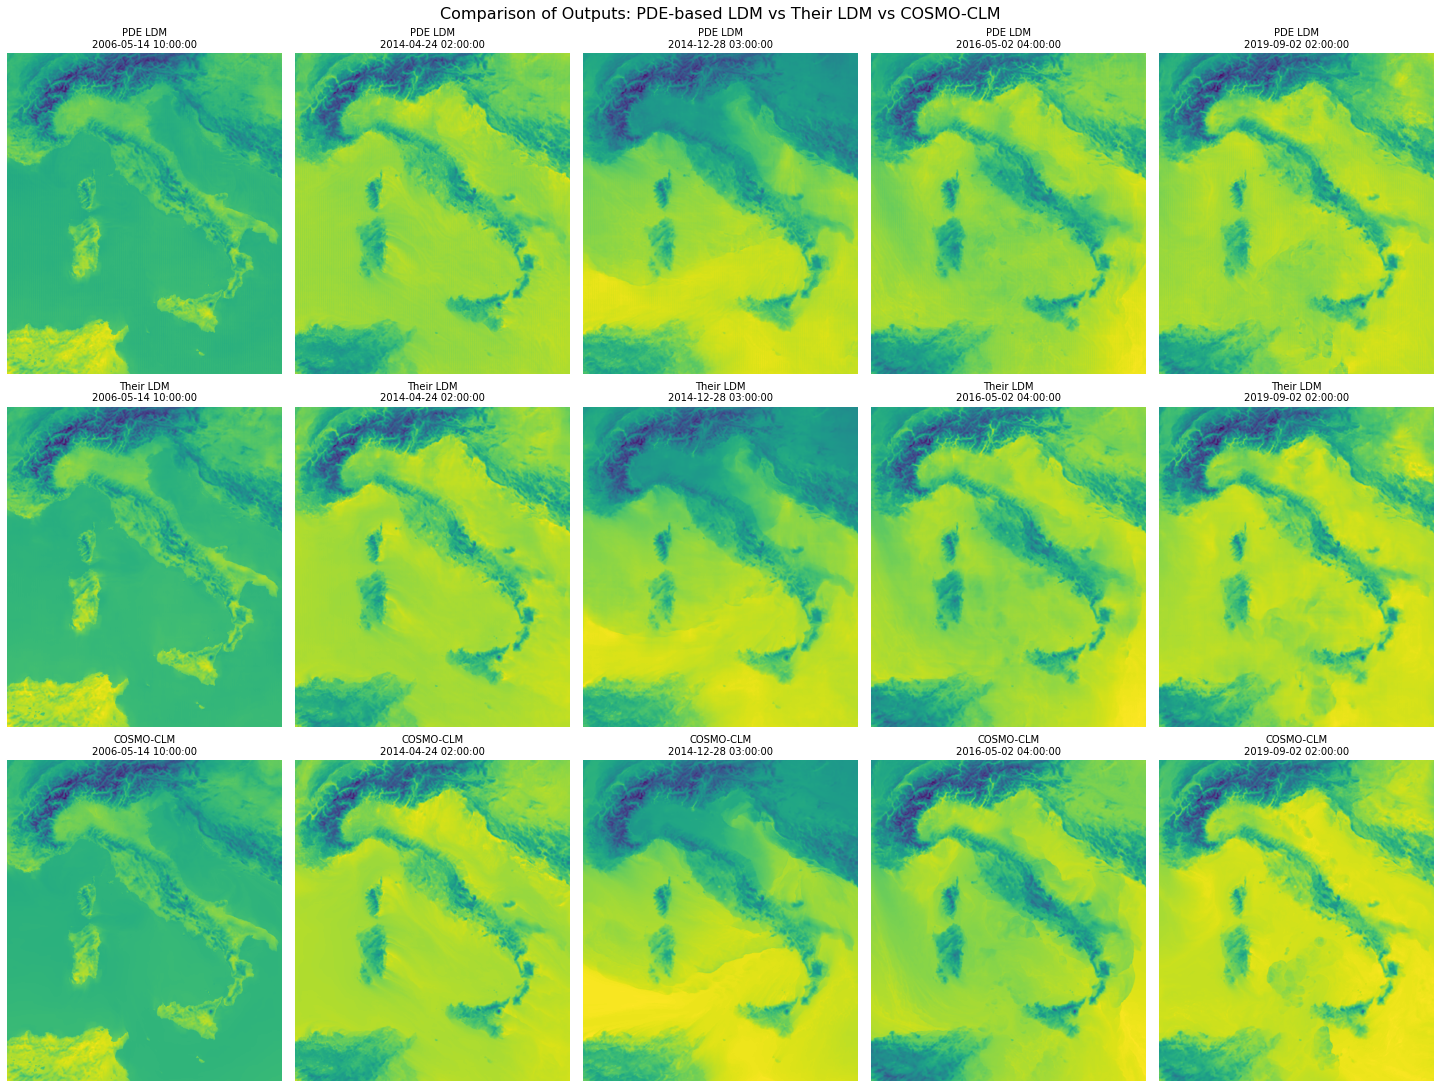

In [13]:
# %% Plot Outputs in Three Rows: PDE-based LDM, Their LDM, and COSMO-CLM Baseline

import matplotlib.pyplot as plt

# Get sorted timestamps to display time steps in order.
timestamps = sorted(list(cosmo_norm.keys()))

# Create a figure with 3 rows (one per model) and columns equal to the number of time steps.
fig, axes = plt.subplots(nrows=3, ncols=nr_timesteps, figsize=(4*nr_timesteps, 15),
                         sharex=True, sharey=True, constrained_layout=True)

# First row: Our PDE-based LDM outputs
for col, ts in enumerate(timestamps):
    axes[0, col].imshow(ldm_preds_pde[ts][plot_var])
    axes[0, col].set_title(f"PDE LDM\n{ts}", fontsize=10)
    axes[0, col].axis('off')
axes[0, 0].set_ylabel("PDE-based LDM", fontsize=12, rotation=90, labelpad=10)

# Second row: Their LDM outputs (stored in ldm_preds_norm, renamed to ldm_preds_their for clarity)
for col, ts in enumerate(timestamps):
    axes[1, col].imshow(ldm_preds_norm[ts][plot_var])
    axes[1, col].set_title(f"Their LDM\n{ts}", fontsize=10)
    axes[1, col].axis('off')
axes[1, 0].set_ylabel("Their LDM", fontsize=12, rotation=90, labelpad=10)

# Third row: COSMO-CLM baseline outputs
for col, ts in enumerate(timestamps):
    axes[2, col].imshow(cosmo_norm[ts][plot_var])
    axes[2, col].set_title(f"COSMO-CLM\n{ts}", fontsize=10)
    axes[2, col].axis('off')
axes[2, 0].set_ylabel("COSMO-CLM", fontsize=12, rotation=90, labelpad=10)

fig.suptitle("Comparison of Outputs: PDE-based LDM vs Their LDM vs COSMO-CLM", fontsize=16)
plt.show()


Detailed Metrics per Time Step and Variable:
       Model           Timestamp Variable      RMSE      BIAS        R2  \
0    PDE_LDM 2006-05-14 10:00:00      2mT  0.980060  0.290211  0.949997   
1    PDE_LDM 2014-04-24 02:00:00      2mT  0.713432  0.007089  0.962465   
2    PDE_LDM 2014-12-28 03:00:00      2mT  1.015501  0.249345  0.981330   
3    PDE_LDM 2016-05-02 04:00:00      2mT  0.854957  0.077922  0.963344   
4    PDE_LDM 2019-09-02 02:00:00      2mT  0.845566  0.091017  0.963958   
5  Their_LDM 2006-05-14 10:00:00      2mT  0.822988  0.164195  0.964740   
6  Their_LDM 2014-04-24 02:00:00      2mT  0.575743 -0.053944  0.975555   
7  Their_LDM 2014-12-28 03:00:00      2mT  0.927947  0.102323  0.984411   
8  Their_LDM 2016-05-02 04:00:00      2mT  0.762229  0.030945  0.970864   
9  Their_LDM 2019-09-02 02:00:00      2mT  0.740493 -0.059151  0.972359   

        PCC  
0  0.977213  
1  0.981753  
2  0.991417  
3  0.981936  
4  0.982534  
5  0.982937  
6  0.987888  
7  0.992374  
8  

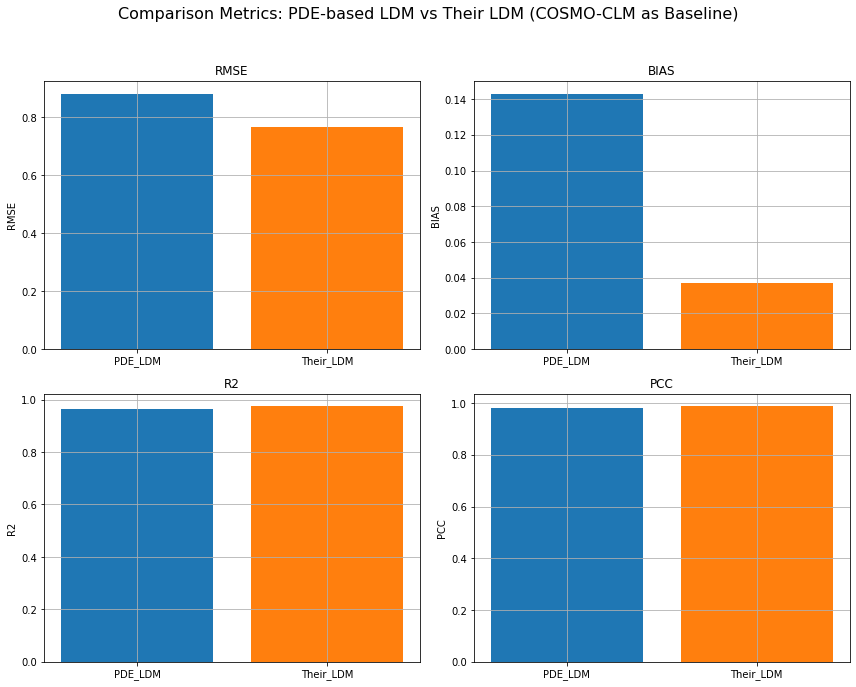

In [14]:
# %% Compute Metrics: RMSE, BIAS, R2, and PCC for PDE-based LDM vs Their LDM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def compute_metrics(pred, truth):
    """
    Compute RMSE, BIAS, R2 and PCC between prediction and truth.
    Converts PyTorch tensors to numpy arrays if necessary.
    """
    # Convert tensors to numpy arrays if needed
    if hasattr(pred, "cpu"):
        pred = pred.cpu().numpy()
    if hasattr(truth, "cpu"):
        truth = truth.cpu().numpy()
    
    rmse = np.sqrt(np.mean((pred - truth)**2))
    bias = np.mean(pred - truth)
    # r2_score expects 1D arrays, so we flatten them
    r2 = r2_score(truth.flatten(), pred.flatten())
    # Pearson correlation coefficient
    pcc = np.corrcoef(pred.flatten(), truth.flatten())[0, 1]
    return {'RMSE': rmse, 'BIAS': bias, 'R2': r2, 'PCC': pcc}

# Dictionary to store metrics for each model and timestamp/variable
metrics_results = {'PDE_LDM': [], 'Their_LDM': []}

# Get sorted timestamps to ensure the results are in order.
timestamps = sorted(list(cosmo_norm.keys()))

# Loop over the two models:
# - 'ldm_preds_pde' contains our PDE-based LDM predictions.
# - 'ldm_preds_norm' contains their LDM predictions.
for model_name, model_preds in zip(['PDE_LDM', 'Their_LDM'], [ldm_preds_pde, ldm_preds_norm]):
    for ts in timestamps:
        for tv in target_vars['high_res']:
            # Compute metrics comparing the model's prediction to the COSMO-CLM baseline.
            metrics = compute_metrics(model_preds[ts][tv], cosmo_norm[ts][tv])
            metrics_results[model_name].append({
                'Model': model_name,
                'Timestamp': ts,
                'Variable': tv,
                'RMSE': metrics['RMSE'],
                'BIAS': metrics['BIAS'],
                'R2': metrics['R2'],
                'PCC': metrics['PCC']
            })

# Combine results into a DataFrame
metrics_df = pd.DataFrame(metrics_results['PDE_LDM'] + metrics_results['Their_LDM'])
print("Detailed Metrics per Time Step and Variable:")
print(metrics_df)

# Compute average metrics across all time steps and variables for each model,
# aggregating only the numeric metric columns.
avg_metrics = metrics_df.groupby('Model')[['RMSE', 'BIAS', 'R2', 'PCC']].mean().reset_index()
print("\nAverage Metrics per Model:")
print(avg_metrics)

# Plot the average metrics in a 2x2 grid (one subplot per metric)
metrics_names = ['RMSE', 'BIAS', 'R2', 'PCC']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_names):
    for model in avg_metrics['Model']:
        value = avg_metrics.loc[avg_metrics['Model'] == model, metric].values[0]
        axes[i].bar(model, value)
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].grid(True)

fig.suptitle("Comparison Metrics: PDE-based LDM vs Their LDM (COSMO-CLM as Baseline)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [19]:

# A small constant for stabilization.
eps = 1e-6


def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Compute finite-difference gradients (with proper boundary handling)
def compute_gradients_torch(T, dx=1.0, dy=1.0, eps=1e-6):
    """
    Given a 2D torch.Tensor T, compute the finite-difference gradients in x (dTdx)
    and y (dTdy) using centered differences for interior points and one-sided differences
    on the boundaries.
    """
    H, W = T.shape
    dTdx = torch.zeros_like(T)
    dTdy = torch.zeros_like(T)
    
    # Interior: centered differences.
    if W > 2:
        dTdx[:, 1:-1] = (T[:, 2:] - T[:, :-2]) / (2.0 * dx)
    if H > 2:
        dTdy[1:-1, :] = (T[2:, :] - T[:-2, :]) / (2.0 * dy)
    
    # Boundaries in x.
    if W > 1:
        dTdx[:, 0] = (T[:, 1] - T[:, 0]) / dx   # left boundary
        dTdx[:, -1] = (T[:, -1] - T[:, -2]) / dx   # right boundary
    else:
        dTdx[:, 0] = 0.0

    # Boundaries in y.
    if H > 1:
        dTdy[0, :] = (T[1, :] - T[0, :]) / dy   # top boundary
        dTdy[-1, :] = (T[-1, :] - T[-2, :]) / dy   # bottom boundary
    else:
        dTdy[0, :] = 0.0
        
    return dTdx, dTdy

###############################################################################
# Compute the effective flux ratio for a given block (supercell)
###############################################################################
def compute_block_effective_flux_ratio_torch(T_block, dTdx_block, dTdy_block, dx=1.0, dy=1.0, eps=1e-6):
    """
    For the given block (supercell) represented by T_block and its precomputed gradients,
    compute the effective flux ratio R_eff based on the boundary values:
    
        R_eff = (mean of [T * (g_hat · n)] over boundary) / (mean of [||grad T||] over boundary + eps)
    
    where g_hat is the unit gradient and n is the outward normal (set per edge).
    """
    device = T_block.device
    H, W = T_block.shape
    adv_vals = []
    diff_vals = []
    
    # Helper: process one edge given index arrays (1D tensors) and an outward normal.
    def process_edge(i_idx, j_idx, nx, ny):
        grad_x = dTdx_block[i_idx, j_idx]
        grad_y = dTdy_block[i_idx, j_idx]
        Tvals  = T_block[i_idx, j_idx]
        grad_norm = torch.sqrt(grad_x**2 + grad_y**2) + eps
        g_hat_x = grad_x / grad_norm
        g_hat_y = grad_y / grad_norm
        dot = g_hat_x * nx + g_hat_y * ny
        adv = Tvals * dot
        diff = torch.sqrt(grad_x**2 + grad_y**2)
        return adv, diff

    # Top edge: row 0, all columns.
    if H > 0:
        i_top = torch.zeros(W, dtype=torch.long, device=device)
        j_top = torch.arange(W, device=device)
        adv, diff = process_edge(i_top, j_top, nx=0.0, ny=-1.0)  # n pointing upward
        adv_vals.append(adv)
        diff_vals.append(diff)

    # Bottom edge: row H-1, all columns.
    if H > 1:
        i_bot = torch.full((W,), H - 1, dtype=torch.long, device=device)
        j_bot = torch.arange(W, device=device)
        adv, diff = process_edge(i_bot, j_bot, nx=0.0, ny=1.0)   # n pointing downward
        adv_vals.append(adv)
        diff_vals.append(diff)

    # Left edge: column 0, rows 1 to H-2 (avoid double counting corners).
    if W > 0 and H > 2:
        i_left = torch.arange(1, H - 1, device=device)
        j_left = torch.zeros(H - 2, dtype=torch.long, device=device)
        adv, diff = process_edge(i_left, j_left, nx=-1.0, ny=0.0)  # n pointing left
        adv_vals.append(adv)
        diff_vals.append(diff)

    # Right edge: column W-1, rows 1 to H-2.
    if W > 1 and H > 2:
        i_right = torch.arange(1, H - 1, device=device)
        j_right = torch.full((H - 2,), W - 1, dtype=torch.long, device=device)
        adv, diff = process_edge(i_right, j_right, nx=1.0, ny=0.0)   # n pointing right
        adv_vals.append(adv)
        diff_vals.append(diff)

    if len(adv_vals) == 0:
        return 0.0

    adv_all = torch.cat(adv_vals)
    diff_all = torch.cat(diff_vals)
    return (torch.mean(adv_all) / (torch.mean(diff_all) + eps)).item()

###############################################################################
# Partition the field into supercells and compute the effective flux ratio for each
###############################################################################
def compute_supercell_flux_ratio_field(T, supercell_size, dx=1.0, dy=1.0, eps=1e-6):
    """
    Accepts a 2D field T (either a numpy array or a torch.Tensor), partitions it into
    non-overlapping supercells of size (supercell_size x supercell_size), and computes the 
    effective flux ratio (R_eff) for each supercell. Returns a 2D numpy array with shape
    (num_cells_vertical x num_cells_horizontal).
    """
    device = get_device()
    # Convert input to torch tensor if it's not already, and move to the proper device.
    if not isinstance(T, torch.Tensor):
        T_torch = torch.from_numpy(T).float().to(device)
    else:
        T_torch = T.float().to(device)
    
    H, W = T_torch.shape
    # Compute gradients for the entire field.
    dTdx, dTdy = compute_gradients_torch(T_torch, dx=dx, dy=dy, eps=eps)
    
    num_cells_vert = H // supercell_size
    num_cells_horiz = W // supercell_size
    R_eff_field = torch.zeros((num_cells_vert, num_cells_horiz), device=device)
    
    for i in range(num_cells_vert):
        for j in range(num_cells_horiz):
            r0, r1 = i * supercell_size, (i + 1) * supercell_size
            c0, c1 = j * supercell_size, (j + 1) * supercell_size
            T_block    = T_torch[r0:r1, c0:c1]
            dTdx_block = dTdx[r0:r1, c0:c1]
            dTdy_block = dTdy[r0:r1, c0:c1]
            
            R_eff = compute_block_effective_flux_ratio_torch(T_block, dTdx_block, dTdy_block, dx=dx, dy=dy, eps=eps)
            R_eff_field[i, j] = R_eff

    return R_eff_field.cpu().numpy()

###############################################################################
# Compute the flux ratio loss on the supercell grid between a reference and predicted field.
###############################################################################
def compute_flux_ratio_loss_supercell(ref_field, pred_field, supercell_size, dx=1.0, dy=1.0, eps=1e-6):
    """
    Given a reference field and a predicted field (either as 2D numpy arrays or torch.Tensors),
    compute the effective flux ratio field on the supercell grid (of size supercell_size) for each,
    then compute the mean absolute difference (loss) between them. Also returns the R_eff fields.
    """
    R_ref = compute_supercell_flux_ratio_field(ref_field, supercell_size, dx, dy, eps)
    R_pred = compute_supercell_flux_ratio_field(pred_field, supercell_size, dx, dy, eps)
    # In case dimensions differ, take the overlapping region.
    if R_ref.shape != R_pred.shape:
        min_h = min(R_ref.shape[0], R_pred.shape[0])
        min_w = min(R_ref.shape[1], R_pred.shape[1])
        R_ref = R_ref[:min_h, :min_w]
        R_pred = R_pred[:min_h, :min_w]
    loss = np.mean(np.abs(R_pred - R_ref))
    return loss, R_ref, R_pred

Average Flux Ratio Loss (Mean Absolute Difference) compared to ERA5:
  Quadratic Interp.: 914.92273
  UNET: 1080.05957
  GAN: 976.02557
  LDM_res (Their): 865.16357
  LDM_res (PDE): 702.10809


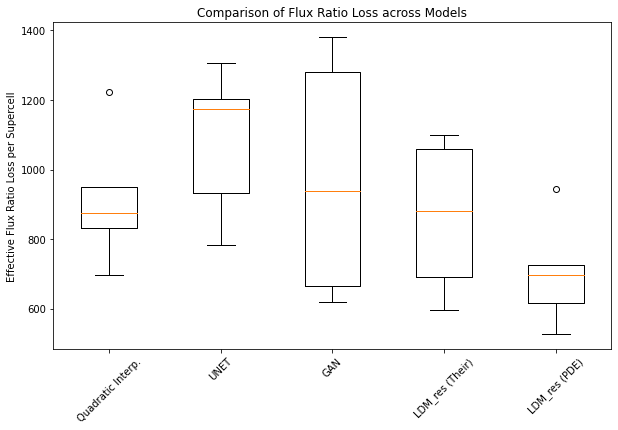

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the flux ratio analysis
supercell_size = 32
dx = 1.0
dy = 1.0
eps = 1e-6


# Define a dictionary of all prediction models to compare.
# The keys correspond to the model names and the values are the dictionaries that store predictions per timestamp.
models = {
    "Quadratic Interp.": quadratic_norm,
    "UNET": unet_preds_norm,
    "GAN": gan_preds_norm,
    "LDM_res (Their)": ldm_preds_norm,   # their LDM predictions
    "LDM_res (PDE)": ldm_preds_pde        # PDE-based LDM predictions
    
}

# Create a dictionary to store the per-timestamp loss for each model.
losses = {model: [] for model in models.keys()}

# Ensure that the ERA5 reference predictions are available for every timestamp.
# 'era5_norm' should be the dictionary storing ERA5 fields (our reference).
timestamps_sorted = sorted(list(era5_norm.keys()))

# Loop over each timestamp, compare the effective flux ratio of the reference field with each model.
for ts in timestamps_sorted:
    # Reference flux field (ERA5) for the given timestamp.
    ref_field = era5_norm[ts][plot_var]
    
    for model_name, pred_dict in models.items():
        if ts in pred_dict:
            pred_field = pred_dict[ts][plot_var]
            # Compute flux ratio loss for this timestamp using our GPU-accelerated function.
            loss, _, _ = compute_flux_ratio_loss_supercell(ref_field, pred_field,
                                                           supercell_size, dx, dy, eps)
            losses[model_name].append(loss)
        else:
            print(f"Timestamp {ts} is missing for model: {model_name}")

# Calculate average loss across all timestamps for each model.
avg_losses = {model: np.mean(losses[model]) if len(losses[model]) > 0 else np.nan
              for model in losses}

print("Average Flux Ratio Loss (Mean Absolute Difference) compared to ERA5:")
for model, loss_val in avg_losses.items():
    print(f"  {model}: {loss_val:.5f}")

# Plotting the distribution of losses over timestamps for each model as a boxplot.
fig, ax = plt.subplots(figsize=(10, 6))
model_names = list(losses.keys())
data_to_plot = [losses[m] for m in model_names]
ax.boxplot(data_to_plot, labels=model_names)
ax.set_ylabel("Effective Flux Ratio Loss per Supercell")
ax.set_title("Comparison of Flux Ratio Loss across Models")
plt.xticks(rotation=45)
plt.show()


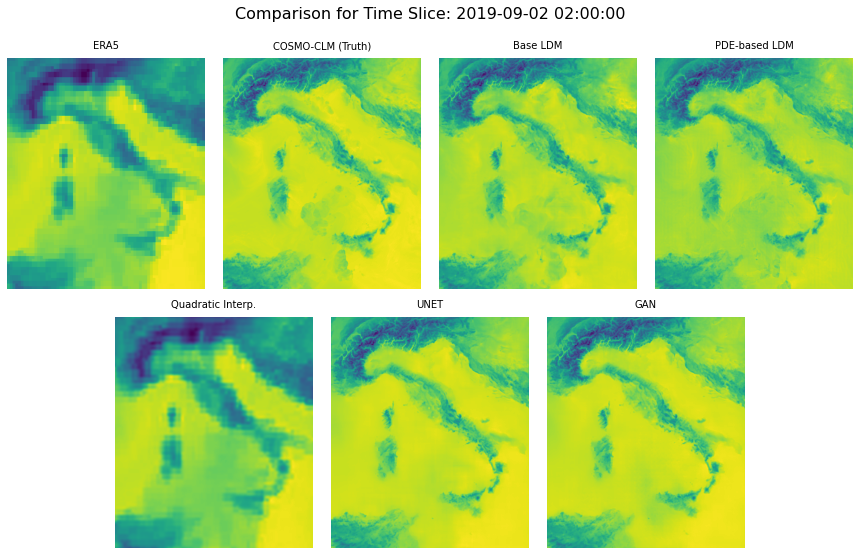

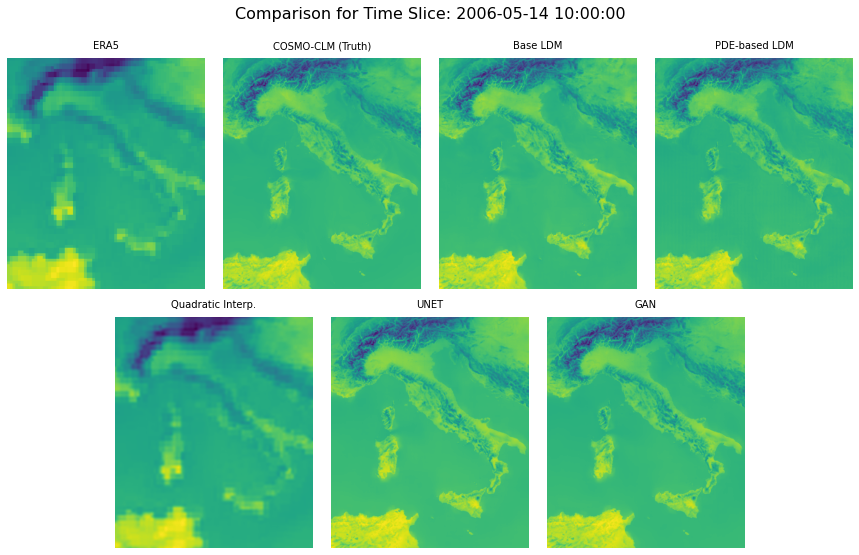

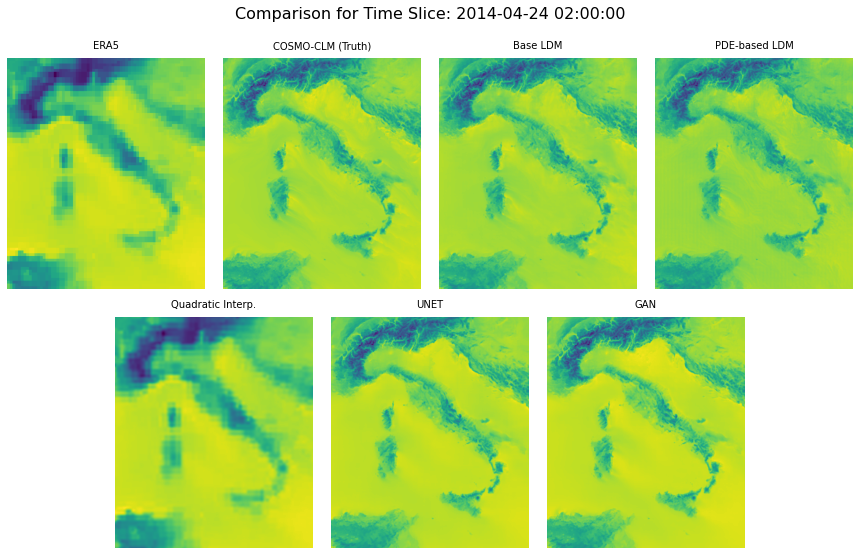

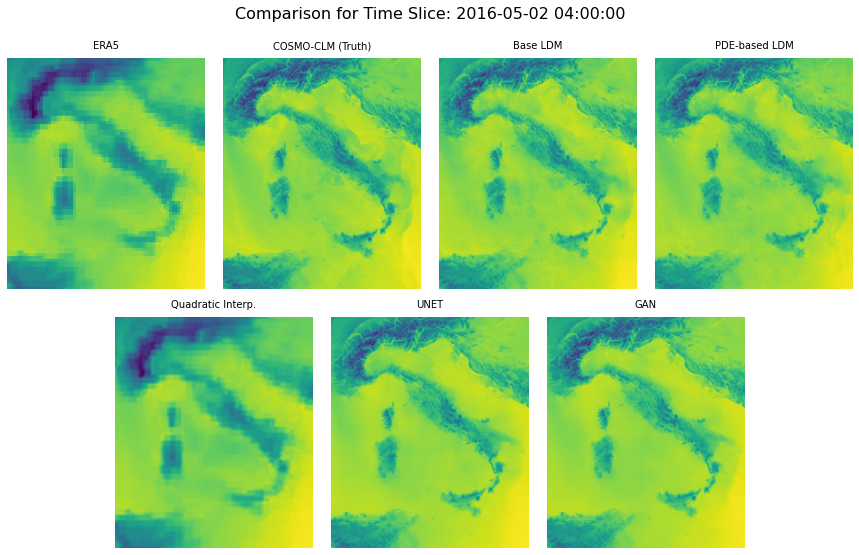

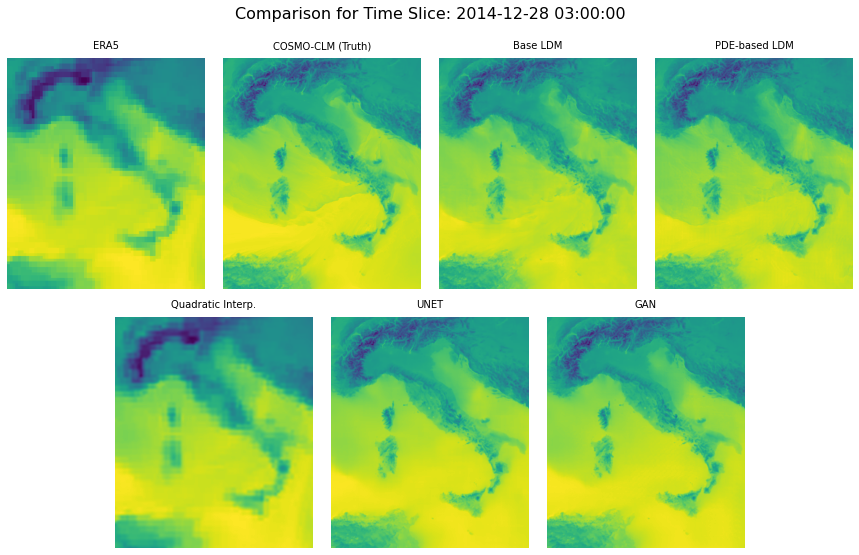

In [ ]:
# ==== Code Cell {} ====
import matplotlib.pyplot as plt
import random

# Randomly select 5 time slices from the available timestamps in cosmo_norm.
selected_timestamps = random.sample(list(cosmo_norm.keys()), 5)

for ts in selected_timestamps:
    # Create a new composite figure for the current time slice.
    fig = plt.figure(figsize=(12, 8))
    # Place the overall figure title (time slice) at y=0.95 to avoid overlap.
    fig.suptitle(f"Comparison for Time Slice: {ts}", fontsize=16, y=0.99)
    
    # --------------------------
    # Top row (4 images) layout.
    # We want each subplot to have a width of 0.25 and a height of 0.4.
    # Moving the top row down a bit (using top_y = 0.50) ensures there is enough gap for the suptitle.
    top_width = 0.25
    top_height = 0.4
    top_y = 0.50
    top_x_positions = [i * top_width for i in range(4)]  # Positions: 0.0, 0.25, 0.50, 0.75.
    
    # 1. ERA5
    ax = fig.add_axes([top_x_positions[0], top_y, top_width, top_height])
    ax.imshow(era5_norm[ts][plot_var])
    ax.set_title("ERA5", fontsize=10, pad=10)
    ax.axis("off")
    
    # 2. Ground Truth COSMO-CLM
    ax = fig.add_axes([top_x_positions[1], top_y, top_width, top_height])
    ax.imshow(cosmo_norm[ts][plot_var])
    ax.set_title("COSMO-CLM (Truth)", fontsize=10, pad=10)
    ax.axis("off")
    
    # 3. Their LDM
    ax = fig.add_axes([top_x_positions[2], top_y, top_width, top_height])
    ax.imshow(ldm_preds_norm[ts][plot_var])
    ax.set_title("Base LDM", fontsize=10, pad=10)
    ax.axis("off")
    
    # 4. PDE-based LDM
    ax = fig.add_axes([top_x_positions[3], top_y, top_width, top_height])
    ax.imshow(ldm_preds_pde[ts][plot_var])
    ax.set_title("PDE-based LDM", fontsize=10, pad=10)
    ax.axis("off")
    
    # --------------------------
    # Bottom row (3 images) layout.
    # These images should have the same size as the top ones (width=0.25).
    # To center 3 images (total width = 3*0.25 = 0.75) on a full-width figure, we compute a left margin.
    left_margin = (1 - 3 * 0.25) / 2  # This equals 0.125.
    bottom_width = 0.25
    bottom_height = top_height  # same as top row.
    bottom_y = 0.05  # Place the bottom row lower in the figure.
    bottom_x_positions = [left_margin + j * bottom_width for j in range(3)]
    
    # 1. Quadratic Interpolation
    ax = fig.add_axes([bottom_x_positions[0], bottom_y, bottom_width, bottom_height])
    ax.imshow(quadratic_norm[ts][plot_var])
    ax.set_title("Quadratic Interp.", fontsize=10, pad=10)
    ax.axis("off")
    
    # 2. UNET
    ax = fig.add_axes([bottom_x_positions[1], bottom_y, bottom_width, bottom_height])
    ax.imshow(unet_preds_norm[ts][plot_var])
    ax.set_title("UNET", fontsize=10, pad=10)
    ax.axis("off")
    
    # 3. GAN
    ax = fig.add_axes([bottom_x_positions[2], bottom_y, bottom_width, bottom_height])
    ax.imshow(gan_preds_norm[ts][plot_var])
    ax.set_title("GAN", fontsize=10, pad=10)
    ax.axis("off")
    
    plt.show()
